# ...(TOPIC: fastball velo itself has little to do with performance, so ...)
Fastball is arguably one of the most interesting aspects to watch in a baseball game: no breaking, no change of speed, but simply pure challenge to the batter. People often first associate fastball with its speed, and there are several reasons to it: 1) most professional leagues use different instruments (e.g. radars, cameras) that can detect the speed of a ball, and can exhibit the number to the audiance right after a pitch (mostly on an giant electronic board), so it becomes the most accessible piece of information; 2) speed is one of the easiest statistics to understand and interpret, and it is somewhat relatable to everyday life (e.g. car speed); 3) fastball usually has the fastest speed among all kind of pitches, which produces the greatest number on the electronic board. Think about this, if you are in a Major League baseball game and a pitcher throws a fastball that reaches three digit (over 100 mph), audiance are going to wow at it.  

As the understanding of kinesiology becomes more advanced these days, athletes are trained to reach beyond their limit that they can never imagine. In baseball, more pitchers are able to throw over 100 miles per hour. However, despite the awe of this speed statistics, is this really guarantee these fireball pitchers to perform well in the league? How about the other pitchers who are not able to throw that fast, are they doomed? Clearly, the answers are no to both questions, since a baseball game is way more complicated to be addressed with just one piece of statistics.   

But at the end of the day, why does fastball speed ever matter? And what about those slower-pitching pitchers, how do they survive? This study aims to explore a number of topics: 
1. Is there any correlation between a fastball speed (average and max) and a performance metric (WHIP)? 
2. Cluster the pitchers into two categories: fastball-based pitchers and non-fastball-based pitchers, and interpret their data 
3. ...(for fastball, is there a combination of pitches (e.g. fastball + changeup, different location) that can most efficiently get rid of batters e.g. strike out)



# Setup

In [268]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats

In [269]:
# read files 
raw_atbats = pd.read_csv('data/2019_atbats.csv')
raw_games = pd.read_csv('data/2019_games.csv')
raw_pitches = pd.read_csv('data/2019_pitches.csv')
raw_players = pd.read_csv('data/player_names.csv')

# Data Cleaning and Wrangling 

First, we need to make sure that all players' ids are included in `raw_players`.

In [270]:
pitcher_ids = raw_atbats['pitcher_id'].unique()
batter_ids = raw_atbats['batter_id'].unique()

for i,n in enumerate(pitcher_ids):
    assert i in raw_players['id']
        
for i,n in enumerate(batter_ids):
    assert i in raw_players['id']

Among the four datasets, the major foucs will be `raw_pitches`. This dataset records every pitch/at-bat in the 2019 MLB season, which is identified by a unique at-bat id (`'ab_id'`). However, it does not specify which pitcher/batter was involved in each at-bat. We therefore extract relevant information from `raw_atbats` (`'ab_id'`,`'pitcher_id'`,`'batter_id'`) and merge it to `raw_pitches`. On top of that, we extract names of pitchers from `raw_players` and merge according to the new `pitcher_id` column*. This allows us to only need to use one dataframe in later sections, and it will be assigned to the variable named `df`.  
  
*Since the project aims to focus on pitching, we skip the merging of batters names.

In [271]:
# extract pitcher_id, batter_id and ab_id (at bat id) from raw_atbats
atbats_extract = raw_atbats[['ab_id','pitcher_id','batter_id']]

# merge df_atbats_extract to df_pitches
pitches_with_ids = pd.merge(raw_pitches, atbats_extract, how='left', on='ab_id')

# create a column full_name in df_players
def get_full_name(str1,str2):
    full_name = str1+' '+str2
    return (str1 + ' ' + str2)

raw_players['full_name']=raw_players.apply(lambda row: get_full_name(row['first_name'],row['last_name']),axis=1)

# merge full name with df_pitches_with_ids and assign the whole dataframe object to df 
df = pd.merge(pitches_with_ids,raw_players, left_on='pitcher_id', right_on='id', how='left')
df = df.drop(columns=['id','first_name','last_name']).rename(columns={'full_name':'pitcher_name'})
df.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,pitcher_id,batter_id,pitcher_name
0,0.00,2.15,88.8,80.7,placeholder,placeholder,22.8,4.8,24.0,-8.47,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,571666,594777,Mike Fiers
1,0.34,2.31,89.9,81.8,placeholder,placeholder,22.8,3.6,24.0,-7.10,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,571666,545361,Mike Fiers
2,-0.05,2.03,85.7,79.6,placeholder,placeholder,9.6,6.0,24.0,3.65,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,571666,545361,Mike Fiers
3,0.49,0.92,85.4,78.5,placeholder,placeholder,24.0,7.2,24.0,-13.77,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,571666,545361,Mike Fiers
4,-0.13,1.11,84.6,77.6,placeholder,placeholder,26.4,8.4,24.0,-15.99,...,1.0,1.0,1.0,4.0,0.0,0.0,0.0,571666,545361,Mike Fiers


## Pitch Group (Fastball, Offspeed, Breaking)

In [272]:
df['pitch_type'].unique()

array(['FF', 'SL', 'CH', 'FT', 'SI', 'KC', 'CU', 'FC', 'FS', 'EP', nan,
       'KN', 'FO'], dtype=object)

According to Statcast (https://baseballsavant.mlb.com/statcast_search), pitch types can be categorized into three major groups: fastball, offspeed and breaking. Below is the list of pitch types that falls into each class:
- Fastball: 4-seam (FF), 2-seam/sinker (SI)**, cutter (FC)
- Offspeed: changeup (CH), split-finger (FS), forkball (FO)***, screwball (SC)
- breaking: curveball (CU), knuckle curve (KC), slow curve (CS), slider (SL), sweeper (ST), slurve (SV), knuckleball (KN), eephus (EP)
  
The source of our datasets (https://www.kaggle.com/datasets/pschale/mlb-pitch-data-20152018) also provides pitch type definitions. While most of the abbreviations correspond with Statcast, some are actually different. 
1. The dataset has 2-seam fastball (FT) as a seperate category from sinker. 
2. FO is pitchout in the dataset, instead of fork ball.
3. Some of the pitch types in Statcast do not exist in the dataset. In other words, in the dataset some of the pitches might be put into a more general term (e.g. slow curve might be identified as curveball). Despite the differences, the matter would not be significant in this study because we will not dive into the performance of each specific pitch type (instead, we will just look at fastball or breaking ball in general).
  
Combined, we will group the pitch types into the following order:
- Fastball: FF, FT, FC, SI
- Offspeed: CH, FS
- Breaking: CU, KC, SL, KN, EP
- Other: FO, nan 

In [273]:
# categorize each pitch type ('pitch_type') into one of fastball, offspeed, breaking or unknown 

def map_categorize_pitch(pitch):
    if pitch in ['FF','FT','FC','SI']:
        return 'fastball'
    elif pitch in ['CH', 'FS', 'FO']:
        return 'offspeed'
    elif pitch in ['CU', 'KC', 'SL', 'KN', 'EP']:
        return 'breaking'
    else: 
        return 'unknown'

df['pitch_group'] = df['pitch_type'].apply(map_categorize_pitch)
df[['pitch_type','pitch_group']].head()

,pitch_type,pitch_group
0,FF,fastball
1,FF,fastball
2,SL,breaking
3,CH,offspeed
4,CH,offspeed


## Pitchers Statistics 

The goal here is to summarize the statistics of each pitchers from `df`, which will be stored in a different variable called `players`. Below is a list of statistics that we will summarize for each pitcher: 
- walks
- hits
- ip
- WHIP (walks and hits per inning pitched)
- average fastball speed 
- K/9 (strikeouts per nine innings)  
...
- fastball usage ratio
- offspeed ball usage ratio
- breaking ball usage ratio
- ...tbd
  

Details and usages of these features will be introduced in later sections. 

### Walks, Hits, Innings Pitched, and WHIP
WHIP (walks and hits per inning pitched) is a widely used metric to measure the goodness of a pitcher (details see 1. Correlation Between Average Fastball Speed and WHIP). It is calculated by three other statstics of a pitcher, walks, hits and innings pitched (ip). For each pitcher, we summarize these four statistics and stored the data to `players`.

In [274]:
# walks: count any ball event ('code' == 'B') when ball count ('b_count') is already 3 
s_walks = df[(df['code'] == 'B') & (df['b_count'] == 3)].groupby('pitcher_id').size().rename('walks')

# hits: when an event code is either 'in play, no out' ('D') or 'in play, runs' ('E')
s_hits = df[(df['code'] == 'D') | (df['code'] == 'E')].groupby('pitcher_id').size().rename('hits')

# innings pitched (ip) = (batters out)/3. 
atbats = raw_atbats.copy()
atbats['prev_o']=atbats['o'].shift(1).fillna(0) # 'o' is the total out count of that inning after the at-bat event

def get_n_out(o,prev_o):
    '''
    if a pitcher gets one more out, it should return 1. 
    if double play happens, it will return 2 (and 3 for triple play).
    '''
    if prev_o>o: 
        return o-0 # makes sure prev_o is reset to 0 at any change of inning
    else:
        return o-prev_o 

atbats['n_out']=atbats.apply(lambda row: get_n_out(row['o'], row['prev_o']), axis=1)
s_ip = atbats.groupby('pitcher_id')['n_out'].sum()/3


# create the dataframe players 
players = pd.concat([s_walks,s_hits,s_ip], axis=1, join='outer',keys=['walks','hits','ip']).fillna(0)
# Drop those who failed to get any out (because their ip = 0 and will be meaningless to calculate their WHIP.)
players = players[players['ip'] != 0] 


# WHIP = (walks+hits)/ip
def get_whip(w,h,ip):
    return (w+h)/ip

players['whip']=players.apply(lambda row: get_whip(row['walks'],row['hits'],row['ip']), axis=1)
print(players.head())


            walks   hits          ip      whip
pitcher_id                                    
282332       34.0  120.0  107.333333  1.434783
407845       20.0   50.0   46.000000  1.521739
424144        7.0   43.0   40.333333  1.239669
425794       45.0  189.0  171.666667  1.363107
425844       19.0  189.0  208.666667  0.996805


### Average Fastball Speed 
In `df`, both `start_speed` and `end_speed` of a pitch are given. According to the source of the dataset, start speed is measured when the ball leaves a pitcher's hand, whereas end speed is the speed when the ball reaches the plate. End speed is expected to be affected by drag, for which the extent is unknown, and greater variablility may exist. Therefore in this study, whenever the speed of pitch is mentioned, only `start_speed` will be used.

In [275]:
# average fastball speed
s_afs = df[df['pitch_group']=='fastball'].groupby('pitcher_id')['start_speed'].mean().rename('avg_fastball_speed')

# prevent ValueError produced by running this cell multiple times
try:
    players = players.join(s_afs)
except ValueError:
    pass

players.head()

,walks,hits,ip,whip,avg_fastball_speed
pitcher_id,,,,,
282332,34.0,120.0,107.333333,1.434783,88.547390
407845,20.0,50.0,46.000000,1.521739,93.802245
424144,7.0,43.0,40.333333,1.239669,91.686103
425794,45.0,189.0,171.666667,1.363107,88.018625
425844,19.0,189.0,208.666667,0.996805,89.937648


### K/9
K/9 (strikeouts per nine innings) rate measures the strikeout aspect of a pitcher (details see 2. Correlation Between Average Fastball Speed and K/9). Both the total number of strikeouts and K/9 will be calculated for each pitcher. 


In [276]:
# find all the notations that are considered strikeout
for i in atbats['event'].unique():
    if 'strike' in i or 'Strike' in i:
        print(i)

Strikeout
Strikeout Double Play


In [279]:
# total number of strikeouts 
s_k = (
    atbats[(atbats['event']=='Strikeout') | (atbats['event']=='Strikeout Double Play')]
    .groupby('pitcher_id')
    .size()
    .rename('total_k')
)

try:
    players = players.join(s_k)
except ValueError:
    pass

players['total_k'].fillna(0, inplace=True)

# K/9
players['k9'] = (players['total_k']/players['ip']) * 9
players.head()

,walks,hits,ip,whip,avg_fastball_speed,total_k,k9
pitcher_id,,,,,,,
282332,34.0,120.0,107.333333,1.434783,88.547390,107.0,8.972050
407845,20.0,50.0,46.000000,1.521739,93.802245,48.0,9.391304
424144,7.0,43.0,40.333333,1.239669,91.686103,48.0,10.710744
425794,45.0,189.0,171.666667,1.363107,88.018625,153.0,8.021359
425844,19.0,189.0,208.666667,0.996805,89.937648,187.0,8.065495


# 1. Correlation Between Average Fastball Speed and WHIP 

To measure a goodness of a pitcher, there are several useful metrics including ERA (earned run average), FIP (fielding independent pitching), WHIP (walks and hits per inning pitched), and more. This study will use WHIP as the main metric, due to the following reasons:
1. The formula of WHIP is relatively simple (mlb.com). The formula is: 
\begin{align}
WHIP = \frac{Walks + Hits}{innings\;pitched}
\end{align}
which means that a pitcher with a lower WHIP tends to be better, because he allows less walks and hits in the game.
2. It targets one of the most fundamental goals of a pitcher: keeping runners off the basepaths (that is, minimize the walks and hits) (mlb.com). 
  
Note that WHIP also has its shortcomings: "hit batsmen, errors and hitters who reach via fielder's choice do not count against a pitcher's WHIP" (mlb.com). Nevertheless, WHIP would still be a good and simple starting point to measure the performacne among pitchers. 
  
Below is the plot of pitchers average fastball speed versus WHIP, with the correlation coefficient. 
Since nan values may exist in the column avg_fastball_speed (for those who did not throw any fastballs), we need to drop the rows before calculating the correlation coefficient.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


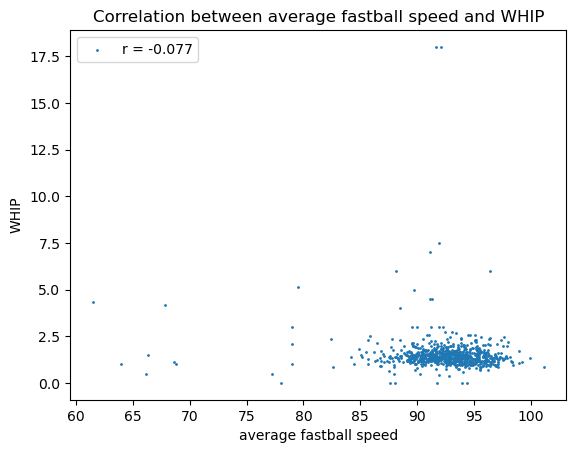

In [285]:
# only keep the rows where a pitcher did throw at least one fastball in the season
players_fb = players.dropna(subset=['avg_fastball_speed'])

# calculate the correlation coefficient
r_whip = np.corrcoef(players_fb['avg_fastball_speed'],players_fb['whip'])[0,1]

players_fb.plot.scatter(x='avg_fastball_speed', y='whip', s=1, label=f'r = {r_whip:.3f}')
plt.xlabel('average fastball speed')
plt.ylabel('WHIP')
plt.title('Correlation between average fastball speed and WHIP')
plt.show()

No clear linear relationship can be observed from the two variables. So why does fastball speed matter after all? 

# 2. Correlation Between Average Fastball Speed and K/9

Recall that in WHIP, the numerator is (walks + hits), which means that how a batter got out (e.g. strikeout, fly-out, ground-out, etc.) is not taken into calculation. Among these conditions, strikeout is the only one that does not need to depend on other defensive factors - in other words, only in the event of a strikeout, ball is never in play and no fielding error will be made, and the out is 100% contributed by the pitcher's effort.  
  
K/9 (strikeouts per nine innings) rate measures how many strikeouts a pitcher averages for every nine innings pitched (mlb.com). The formula of K/9 is:
\begin{align}
K/9 = \frac{\Sigma strikeouts}{innings}\times9
\end{align}
  
Note that it is inappropriate to measure the goodness of a pitcher based on his K/9, since strikeout is not the only way to take out a batter.

Does pitchers who have a faster average fastball speed tend to score higher in K/9? The plot below shows the correlation between avaerage fastball speed and K/9.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


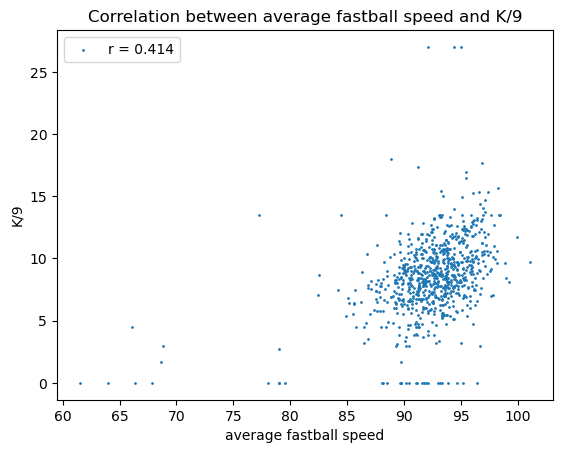

In [287]:
# calculate the correlation coefficient
r_k9 = np.corrcoef(players_fb['avg_fastball_speed'],players_fb['k9'])[0,1]

players_fb.plot.scatter(x='avg_fastball_speed', y='k9', s=1, label=f'r = {r_k9:.3f}')
plt.xlabel('average fastball speed')
plt.ylabel('K/9')
plt.title('Correlation between average fastball speed and K/9')
plt.show()

The result shows a positive linear relationship between average fastball speed and K/9. While it is only moderate (r=0.414), it is still a lot better than what we got from WHIP (r=-0.077). This suggests that for a pitcher in the MLB, although throwing a very fast fastball has nothing to do with his WHIP score, there is a chance that he tends to get more strikeouts. Again, keep in mind that this relationship neither suggests any cause and effect nor guarantees a better strikeout total.